In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
plt.style.use('ggplot')

def value_imputation(df, column_name, fill_value):
    '''
    Function to fill missing rows with specific value
    '''
    df[column_name] = df[column_name].fillna(fill_value) # which value to indicate missingnes
    return df

# Yellow cabs

## Initial data processing

In [31]:
df = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')

## missing value imputation with values out of range of standard values that we can later recognize
df = (df
    .pipe(value_imputation, column_name='RatecodeID', fill_value=0)
    # gonna assume that it had to be stored in car if there was a problem with server connection
    .pipe(value_imputation, column_name='store_and_fwd_flag', fill_value='Y')
    # most of the time there there is a value of 2.5 so im gonna use it
    .pipe(value_imputation, column_name='congestion_surcharge', fill_value=2.5)
    # im gonna assume there is not airport fee, but mayby better idea is to do it by identifying starting district
    .pipe(value_imputation, column_name='airport_fee', fill_value=0)
    # passengers are problematic, for now assigning -1 value for problematics cases
    .pipe(value_imputation, column_name='passenger_count', fill_value=-1)
    # also adding simple information about traveling time in minutes
    .assign(trip_time_min=lambda x: (x['tpep_dropoff_datetime']-x['tpep_pickup_datetime'])/timedelta(minutes=1))
)

## removing columns with problematic dates, cases where pickup happend after dropoff
df = df.drop(index=df[(df['tpep_dropoff_datetime'] < df['tpep_pickup_datetime'])].index)

# performing some filtering to remove observations with nonsense data, explaination in query
df = df[
    # only valid vendors
    (df['VendorID'].isin([1, 2]))
    # valid dates, personly i found some cases from 2022-10 so idk what happend there
    & (df['tpep_dropoff_datetime'] >= '2023-01-01') & (df['tpep_dropoff_datetime'] <= '2023-02-01')
    & (df['tpep_pickup_datetime'] >= '2023-01-01') & (df['tpep_pickup_datetime'] <= '2023-02-01')
    # so there are cases with negative, or 0 passengers im not sure if the nyc taxi 
    # can work as delivery service that can transport other stuff than people so im gonna remove these cases
    # also i found information that https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page
    # there can be up to 4-5 passengers, and sometimes a child (so up to 6) can be transproted, also keeping my imputed indicator
    & ((df['passenger_count'].between(1, 6)) | (df['passenger_count'] == -1))
    # removing RatecodeID that is not in 0-6, where 0 is imputed value
    & (df['RatecodeID'].between(0, 6)) 
    # this takes only 2 value, we have imputed nulls wiht Y
    & (df['store_and_fwd_flag'].isin(['Y', 'N']))
    # payment type has meaning only for values from range 1-6, 
    & (df['payment_type'].between(1, 6)) 
    # below I make sure that certain variables are only non-negative values, I don't think they have meaning being negative
    & ((df['fare_amount'] >= 0) & (df['extra'] >= 0) & (df['tip_amount'] >= 0) & (df['tolls_amount'] >= 0) & (df['total_amount'] >= 0) )
    # taxes depending on metered rate in use, off or on, sometimes it has weird values so droping them
    & (df['mta_tax'].isin([0, 0.5])) & (df['congestion_surcharge'].isin([0, 2.5])) & (df['airport_fee'].isin([0, 1.25]))
    # filter that is more of a logical explaination, I don't think that anyone will spend more than 1h in a 
    # cab traveling across city and 
    & (df['trip_time_min'] <= 60) & (df['trip_distance'] < 30)
    # also we can't do big distances in too little time (edge case)
    & (
        (df['trip_time_min'] >= 2) 
        # im gonna say like up to 5 miles in 2 minutes possible when traveling on empty road
        | ((df['trip_time_min'] <= 2) & (df['trip_distance'] <= 5))
    )
]
# variables that could be mainpulated but currently I have not idea how to use them
# - improvement_surcharge - it says 0.3 should be most of the time but its not?
# - PULocationID, DOLocationID - i need to prepare mapping that finds if a zone exists, else we drop that record

## filtering data to find "valid trip cases", explained in query
df = (df[(
    # trips that have 0 traveling and are in same district, most likely canceled ones
    # I want to remove observations that changed distrcit but have 0 traveling
    ((df['tpep_dropoff_datetime'] >= df['tpep_pickup_datetime']) & (df['trip_distance'] == 0) & (df['PULocationID'] == df['DOLocationID']))
    # or trips between districts, ie they took some time to travel, distance and start end areas changes
    | ((df['tpep_dropoff_datetime'] > df['tpep_pickup_datetime']) & (df['trip_distance'] > 0) & (df['PULocationID'] != df['DOLocationID']))
    # there may also be trips within a district so lets keep them as long as there is some kind of traveling involved
    | ((df['tpep_dropoff_datetime'] > df['tpep_pickup_datetime']) & (df['trip_distance'] > 0) & (df['PULocationID'] == df['DOLocationID']))
)])


print(len(df))
df.head()

2869283


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time_min
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.00,0.0,1.0,14.30,2.5,0.0,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.00,0.0,1.0,16.90,2.5,0.0,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.0,0.5,15.00,0.0,1.0,34.90,2.5,0.0,12.750000
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0,10.833333
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,12.8,1.0,0.5,10.00,0.0,1.0,27.80,2.5,0.0,12.300000


## Exploration

### Time vs distance

I know that there is stil alot of problematic data entries, there is definetly a problem with a distance and time spent traveling since there are trips that took more than hours with low pay and low distance. There are some cases with very high distance in short time, but I guess these can be possible if there are at the edges of New York?

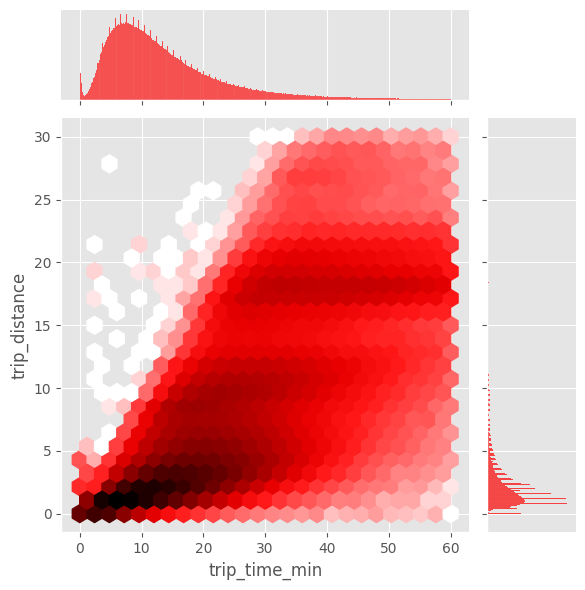

In [32]:
# df_avgrides = df[
#     (df['trip_time_min'] <= 60) 
#     & (df['trip_time_min'] >= 5) 
#     & (df['trip_distance'] <= 100)
# ]
sns.jointplot(df, x='trip_time_min', y='trip_distance', kind="hex", color='red', ratio=4,
              joint_kws=dict(bins='log', gridsize=25))

In [24]:
df_avgrides.shape

NameError: name 'df_avgrides' is not defined

### time trip vs cost

So this one is definetly interesting, time trip vs cost. There are some clear outlier, with insane costs, I actually wonder if these are some kind of penalties rather than wrongly entered data.

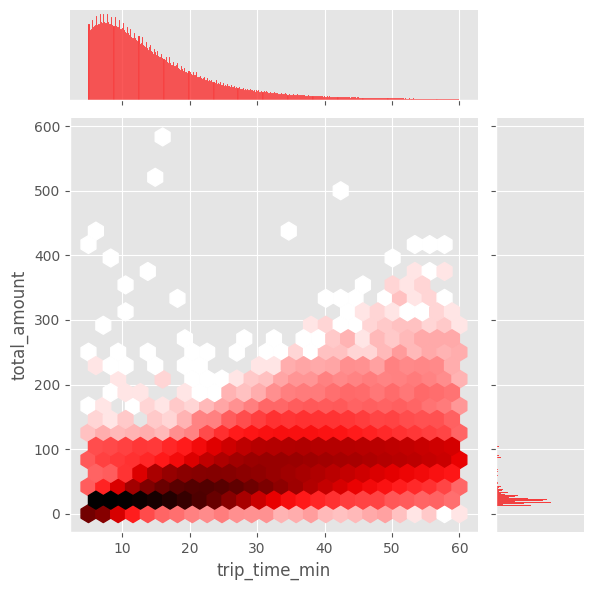

In [ ]:
sns.jointplot(df_avgrides, x='trip_time_min', y='total_amount', kind="hex", color='red', ratio=4,
              joint_kws=dict(bins='log', gridsize=25), )#marginal_kws=dict(kde=True))

### trip distance vs total amount

So even more outliers, short trips with high costs, and long trips with near zero cost.

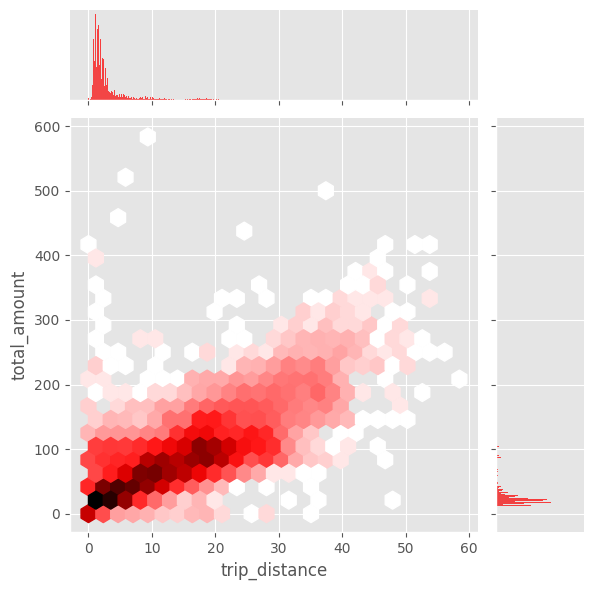

In [ ]:
sns.jointplot(df_avgrides, x='trip_distance', y='total_amount', kind="hex", color='red', ratio=4,
              joint_kws=dict(bins='log', gridsize=25))

In [ ]:
with pd.option_context('display.max_columns', None):
    display(df_avgrides.head(5))

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,RatecodeID_MI,store_and_fwd_flag_MI,congestion_surcharge_MI,airport_fee_MI,trip_time_min
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0,0,0,0,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0,0,0,0,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0,0,0,0,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0,0,0,0,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0,0,0,0,10.833333


## Where are people traveling from to where

Map district to area, get some informations about number of trips, cost, travels, how many trips from each area to other area

# Conclusions

- What are the key factors contribution to the price of a trip
- I should also take a closer look the outliers found in amount vs distance, mayby they are oriented with some kind of late drives where drunk people broke something in a cab?


In [ ]:
df_avgrides[df_avgrides['total_amount'] <0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,passenger_count_MI,RatecodeID_MI,store_and_fwd_flag_MI,congestion_surcharge_MI,airport_fee_MI,trip_time_min


# Green taxis

In [ ]:
# df = pd.read_parquet('../data/green_tripdata_2023-01.parquet')